In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm


from scipy.stats import normaltest #для проверки распределения на нормальность
from statsmodels.graphics.gofplots import qqplot #для проверки распределения на нормальность

from scipy.stats import spearmanr #корреляция Спирмена 

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

from math import log
from math import exp
from scipy.stats import boxcox

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv('resource/Barcelona airbnb 10.2020.csv')

In [4]:
# создание копии для внесения изменений
df_copy = df.copy(deep=True)

In [5]:
df_copy.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


                                  Shape and data types of the data 
                                     (генеральная совокупность)

In [6]:
df_copy.shape

(19896, 16)

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df_copy.columns:
    pct_missing = np.mean(df_copy[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
# Внесение недостающих значений в столбцы name и host_name
df_copy['name'] = df_copy['name'].fillna('MISSING')
df_copy['host_name'] = df_copy['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df_copy = df_copy['name'].str.contains('MISSING')
df_copy[missing_df_copy]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

Text(0.5, 1.0, 'Тепловая карта пропущенных значений')

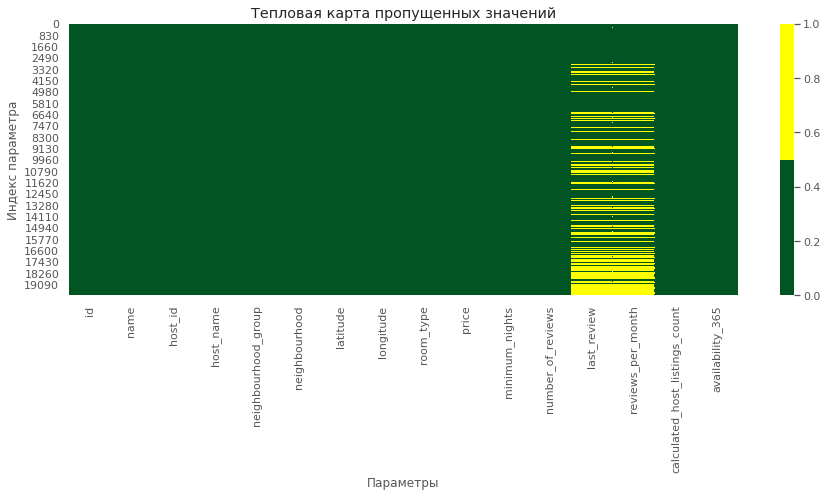

In [11]:
# Отсутствующие значения на тепловой карте
cols = df_copy.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df_copy[cols].isnull(), cmap=sns.color_palette(colours))
plt.xlabel('Параметры')
plt.ylabel('Индекс параметра')
plt.title('Тепловая карта пропущенных значений')

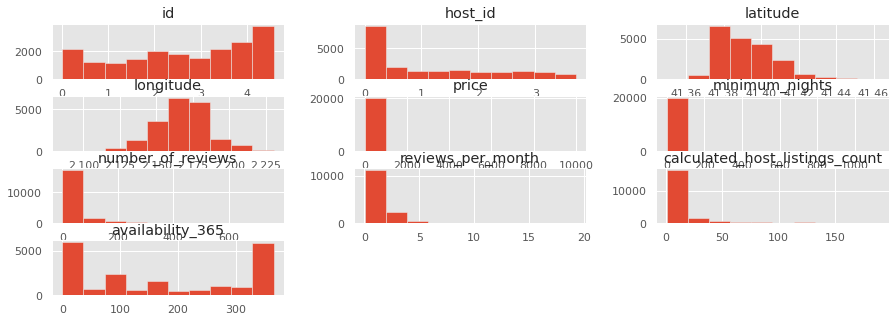

In [12]:
df_copy.hist();

In [13]:
coef, p = spearmanr(df_copy['reviews_per_month'], df_copy['number_of_reviews'])
print('Коэффициент корреляции Спирмена: %.3f' % coef)

alpha = 0.05
if p > alpha:
    print('Статистически значимая корелляция не обнаружена p=%.3f' % p)
else:
    print('Обнаружена статистически значимая корреляция p=%.3f' % p)

Коэффициент корреляции Спирмена: nan
Обнаружена статистически значимая корреляция p=nan


In [14]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df_copy[df_copy['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [15]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [16]:
# замененна значения NAN новым значением 0
df_copy['reviews_per_month'] = df_copy['reviews_per_month'].fillna(0)

In [17]:
# Проверка долей отсутствующих записей для каждого признака после внесения недостающих значений
for col in df_copy.columns:
    pct_missing = np.mean(df_copy[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Exploratory Data analysis

#### Анализ параметра id

In [18]:
# проверка на уникальность
[k for k, v in Counter(df_copy['id']).items() if v > 1]
# все значения id уникальны, повторений нет, следовательно весь датасет содержит уникальные данные

[]

#### Анализ параметра price

In [19]:
# Описательная статистика
df_copy['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [20]:
df_copy['price'].median()

54.0

In [21]:
df_copy['price'].mode()[0]

50

In [22]:
# исключение нулевого значения из набора данных
df_copy = df_copy[df_copy['price'] > 0]

In [23]:
# Проверка распределения на нормальность тестом К^2 Д'Агостино
from scipy.stats import shapiro

data = df_copy.price

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нормальное распределение')
else:
    print('Распределение не является нормальным')

Statistics=52174.124, p=0.000
Распределение не является нормальным


Text(0.5, 1.0, 'Распределение параметра price')

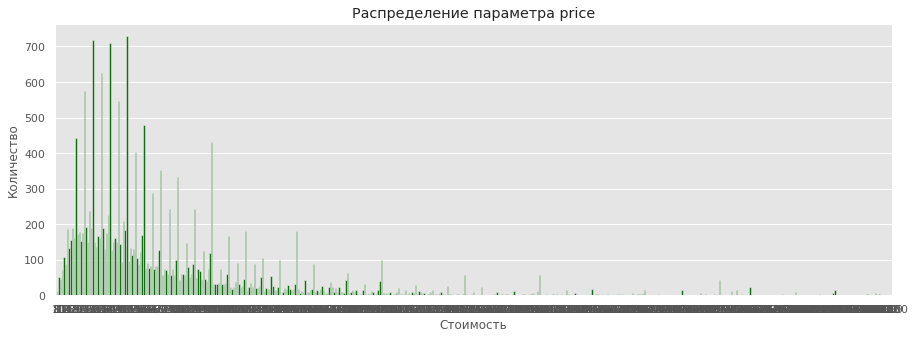

In [24]:
# Распределение параметра price
sns.countplot(x='price', data=df_copy, color='green')
plt.xlabel('Стоимость')
plt.ylabel('Количество')
plt.title('Распределение параметра price')

##### Нетипичные значения

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

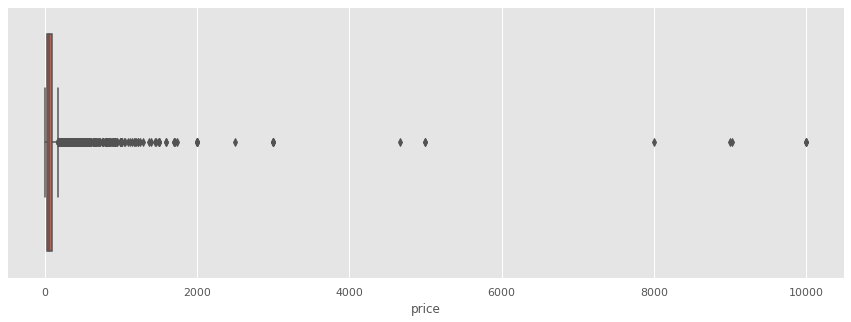

In [25]:
sns.boxplot(df_copy['price'], orient='h')

In [26]:
# Объем нетипичных данных параметра price

df_copy_price = df_copy['price']
upper_quartile = np.percentile(df_copy_price, 75)
lower_quartile = np.percentile(df_copy_price, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df_copy_price[df_copy_price <= upper_quartile +
                              1.5 * iqr].max()  #1.5 межквартильных диапазона

filtered_emissions = df_copy[
    df_copy['price'] >
    upper_whisker]  #выборка данных с нетипичными значениями стоимости

len(filtered_emissions) / len(
    df_copy
) * 100  #процент нетипичных значений стоимости в генеральной совокупности

7.031917567227946

##### Оценка нетипичных данных по длительности аренды

Text(0.5, 1.0, 'Длительность аренды для нетипичных значений')

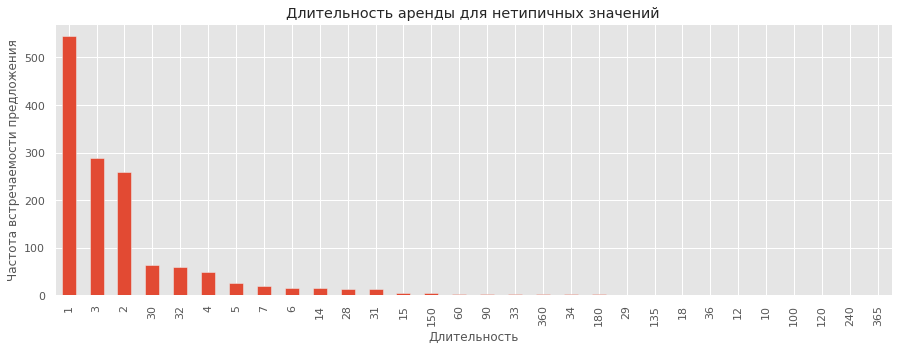

In [27]:
# Длительность аренды для нетипичных значений
filtered_emissions['minimum_nights'].value_counts().plot.bar()
plt.xlabel('Длительность')
plt.ylabel('Частота встречаемости предложения')
plt.title('Длительность аренды для нетипичных значений')

In [28]:
#процент длительной аренды (от месяца до года) в выборке нетипичной стоимости
len(filtered_emissions[filtered_emissions['minimum_nights'] > 29]) / len(
    filtered_emissions) * 100

11.508220157255183

##### Анализ описания предложений по параметру name для выявления маркеров премиальной категории

In [29]:
# Приведение регистров символов к общему виду
df_copy['name'] = df_copy['name'].str.lower()  #нижний регистр для всех строк
filtered_emissions['name'] = filtered_emissions['name'].str.lower(
)  #нижний регистр для всех строк
df_copy['name'] = df_copy['name'].str.strip(
)  #удаление символов в начале и конце строки
df_copy['name'] = df_copy['name'].str.replace('\\.', '')  #удаление точек
df_copy['name'] = df_copy['name'].str.replace('\\bstreet\\b',
                                              'st')  #введение сокращения

<ipython-input-29-0217478cdbf4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emissions['name'] = filtered_emissions['name'].str.lower(


In [30]:
# Поиск наиболее часто встречающихся слов в столбце name генеральной совокупности
Counter(' '.join(df_copy['name']).split()).most_common(10)

[('in', 4725),
 ('room', 4526),
 ('apartment', 3504),
 ('barcelona', 2608),
 ('with', 2213),
 ('the', 2109),
 ('habitación', 1871),
 ('en', 1791),
 ('-', 1671),
 ('de', 1640)]

In [31]:
# Поиск наиболее часто встречающихся слов в столбце name filtered_emissions
Counter(' '.join(filtered_emissions['name']).split()).most_common(10)

[('apartment', 352),
 ('in', 293),
 ('with', 197),
 ('barcelona', 176),
 ('the', 161),
 ('luxury', 108),
 ('de', 107),
 ('-', 101),
 ('room', 99),
 ('terrace', 96)]

In [32]:
# процент предложений с указанием атрибута Lux в генеральной совокупности
df_copy_lux = df_copy[df_copy['name'].str.contains(r'lux*')]
len(df_copy_lux) / len(df_copy) * 100

7.454134204574013

In [33]:
# стандартное отклонение выборки с атрибутом lux
df_copy_lux['price'].std()

378.4141330497012

In [34]:
# процент предложений с указанием атрибута Lux в выборке нетипичной стоимости
df_copy_lux_emission = filtered_emissions[
    filtered_emissions['name'].str.contains(r'lux*')]
len(df_copy_lux_emission) / len(filtered_emissions) * 100

18.799142244460327

In [35]:
# процент краткосрочной аренды с указанием атрибута Lux в выборке нетипичной стоимости
df_copy_lux_emission_short = df_copy_lux_emission[
    df_copy_lux_emission['minimum_nights'] < 29]
len(df_copy_lux_emission_short) / len(filtered_emissions) * 100

15.511079342387418

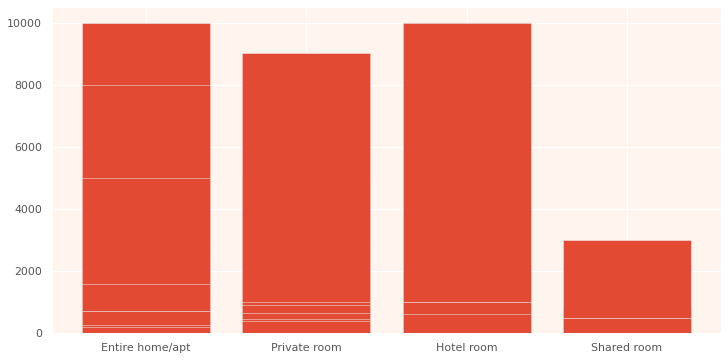

In [36]:
# распределение стоимости по типам предложений в выборке нетипичной стоимости

x = filtered_emissions['room_type']
y1 = filtered_emissions['price']

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(12)  #  ширина Figure
fig.set_figheight(6)  #  высота Figure

plt.show()

In [37]:
# исключение выбросов из - Shared room нетипичной стоимости со сроком аренды менее 30 дней без атрибута Luxury


##### Категоризация параметра price

In [38]:
# Группировка стоимости price_class
price_class = {}

price_category = 1

max_price = df_copy['price'].max() + 1

first_quartile = np.percentile(df_copy.price, 25)
second_quartile = np.percentile(df_copy.price, 50)
third_quartile = np.percentile(df_copy.price, 75)
fourth_quartile = upper_whisker
premium = df_copy['price'].max()

for price in range(1, max_price):

    if (price <= first_quartile):
        price_category = 1

    elif (price > first_quartile and price <= second_quartile):
        price_category = 2

    elif (price > second_quartile and price <= third_quartile):
        price_category = 3

    elif (price > third_quartile and price <= fourth_quartile):
        price_category = 4

    elif (price > fourth_quartile and price <= premium):
        price_category = 5

    price_class[price] = price_category

# price_class

In [39]:
# Добавление столбца с номинативными данными категорий стоимости
df_copy['price_class'] = df_copy['price'].map(price_class)

Text(0.5, 1.0, 'Представление категорий стоимости')

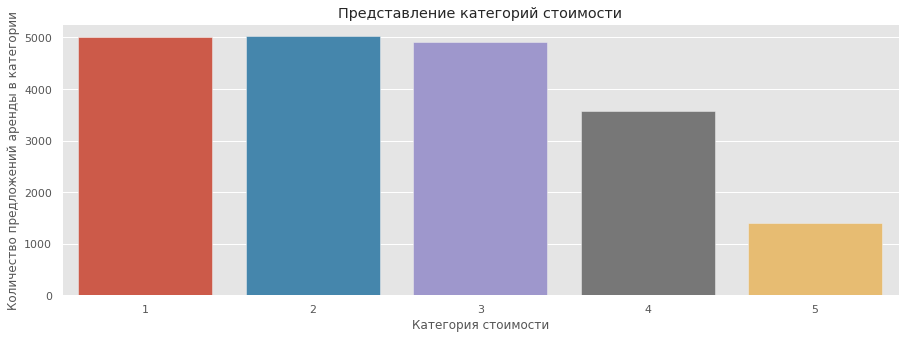

In [40]:
# Распределение параметра price_class
sns.countplot(x='price_class', data=df_copy)
plt.xlabel('Категория стоимости')
plt.ylabel('Количество предложений аренды в категории')
plt.title('Представление категорий стоимости')

####                                    Анализ параметра host id

In [41]:
# проверка на уникальность
df_copy['host_id'].nunique() / len(df_copy)

0.490424729831616

In [42]:
df_copy['host_id'].nunique()

9757

In [43]:
# сравнение частоты встречаемости id каждого хозяина с параметром calculated_host_listings_count в исходных данных

tags, C = np.unique(df.host_id, return_counts=1, return_inverse=1)[1:]
df['host_id_сount'] = C[
    tags]  #создание столбца с числом встречаемости каждого уникального значения host_id

df['filtered_host'] = df['host_id_сount'] == df[
    'calculated_host_listings_count']  #булевое значение при сравнении столбцов
df['filtered_host'].value_counts()

True    19896
Name: filtered_host, dtype: int64

#### Анализ параметра host_name

In [44]:
# объем уникальных значений в столбце host_name
df_copy['host_name'].nunique() / len(df_copy)

0.2100025131942699

In [45]:
# словарь уникальных значений с учетом группировки по host_id
dict_name_host = df_copy.groupby(df_copy.host_name)['host_id'].nunique()

In [46]:
# список наиболее популярных имен с учетом уникальности по параметру host_id
[
    keys for keys, values in dict_name_host.items()
    if values == dict_name_host.max()
]

['Maria']

In [47]:
# Частота встречаемости самого популярного имени
dict_name_host.max() / df_copy['host_id'].nunique()

0.01065901404120119

#### Анализ параметра calculated_host_listings_count

In [48]:
# Количество предложений размещения от одного арендодателя
# У скольких арендодателей 2 предложения аренды? У 1448

df_copy.groupby('host_id').mean()[[
    'calculated_host_listings_count'
]].calculated_host_listings_count.value_counts()

1.0     7027
2.0     1448
3.0      491
4.0      236
5.0      140
        ... 
61.0       1
71.0       1
33.0       1
78.0       1
87.0       1
Name: calculated_host_listings_count, Length: 63, dtype: int64

Text(0.5, 1.0, 'Количество предложений у арендодателей')

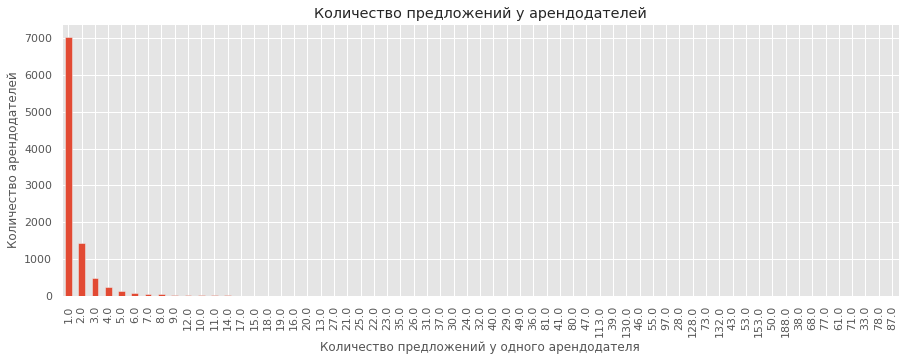

In [49]:
# гистограмма распределения количества предложений аренды у каждого арендодателя
df_copy.groupby('host_id').mean()[[
    'calculated_host_listings_count'
]].calculated_host_listings_count.value_counts().plot.bar()

plt.xlabel('Количество предложений у одного арендодателя')
plt.ylabel('Количество арендодателей')
plt.title('Количество предложений у арендодателей')

In [50]:
# объем арендодателей по количеству предлагаемых вариантов размещения
df_copy.groupby('host_id').mean()[[
    'calculated_host_listings_count'
]].calculated_host_listings_count.value_counts(normalize=True)

1.0     0.720201
2.0     0.148406
3.0     0.050323
4.0     0.024188
5.0     0.014349
          ...   
61.0    0.000102
71.0    0.000102
33.0    0.000102
78.0    0.000102
87.0    0.000102
Name: calculated_host_listings_count, Length: 63, dtype: float64

#### Анализ параметра room_type

In [51]:
df_copy['room_type'].value_counts(normalize=True)

Private room       0.496507
Entire home/apt    0.474391
Hotel room         0.018296
Shared room        0.010807
Name: room_type, dtype: float64

Text(0.5, 1.0, 'Количество предложений по типам размещения')

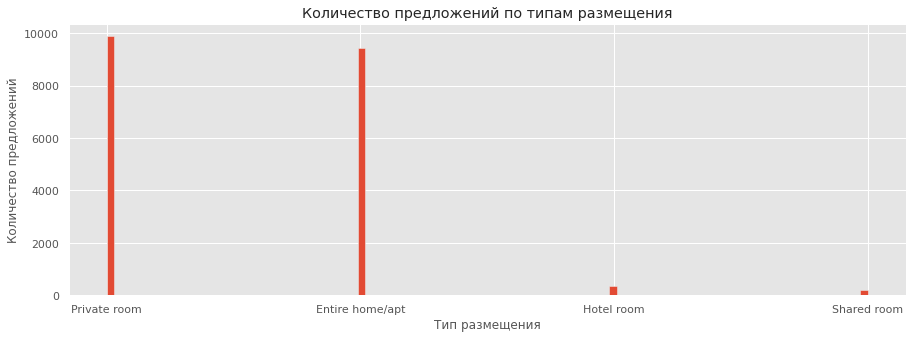

In [52]:
# Количество предложений по типам размещения
df_copy['room_type'].hist(bins=100)
plt.xlabel('Тип размещения')
plt.ylabel('Количество предложений')
plt.title('Количество предложений по типам размещения')

Text(0.5, 1.0, 'Распределение стоимости по типу размещения')

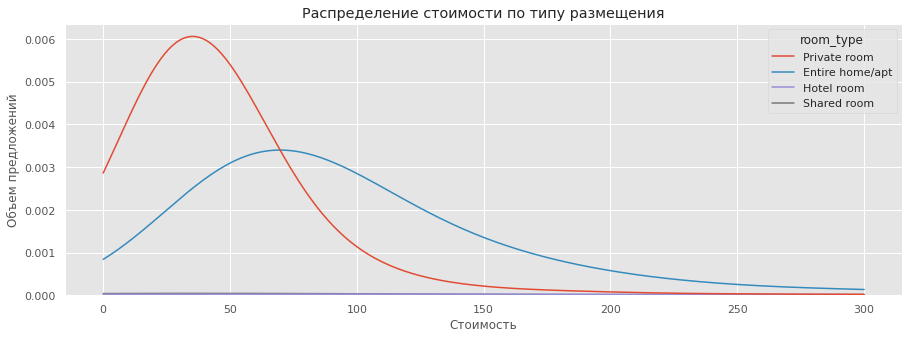

In [53]:
# распределение стоимости по типу размещения
sns.kdeplot(data=df_copy, x='price', hue='room_type', clip=(0, 300))
plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по типу размещения')

In [54]:
# Группировка стоимости price_class
room_class = {}

for room in df_copy['room_type']:
    if (room == 'Private room'):
        room_category = 1

    elif (room == 'Entire home/apt'):
        room_category = 2

    elif (room == 'Hotel room'):
        room_category = 3

    elif (room == 'Shared room'):
        room_category = 4

    room_class[room] = room_category

In [55]:
df_copy['room_class'] = df_copy['room_type'].map(room_class)

####                                  Анализ параметра minimum_nights

In [56]:
df_copy['minimum_nights'].describe()

count    19895.000000
mean        11.369992
std         27.762271
min          1.000000
25%          1.000000
50%          3.000000
75%         29.000000
max       1124.000000
Name: minimum_nights, dtype: float64

Text(0.5, 1.0, 'Количество предложений для аренды по длительности')

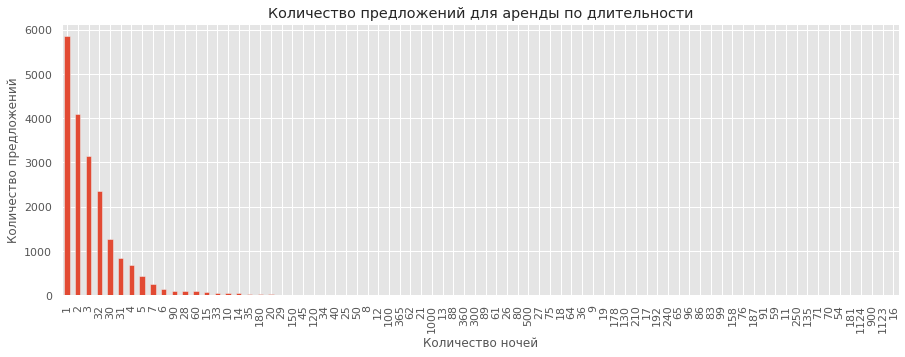

In [57]:
# Распределение minimum_nights
df_copy['minimum_nights'].value_counts().plot.bar()
plt.xlabel('Количество ночей')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по длительности')

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

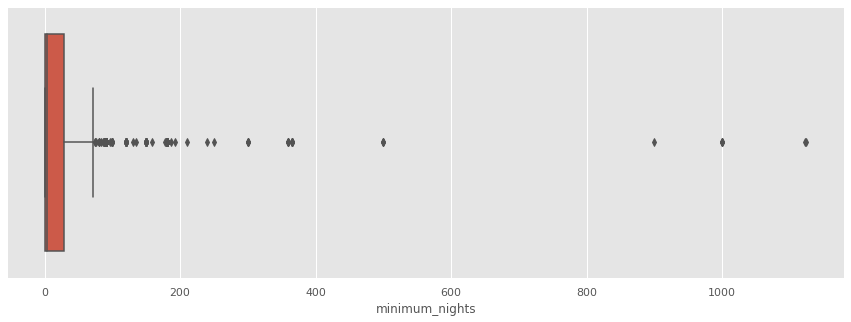

In [58]:
sns.boxplot(df_copy['minimum_nights'], orient='h')

In [59]:
# Группировка по длительности аренды
minimum_nights_class = {}

minimum_nights_category = 1

max_count_nights = df_copy['minimum_nights'].max()

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = '1'

    elif (minimum_nights >= 30):
        minimum_nights_category = '30'

    minimum_nights_class[minimum_nights] = minimum_nights_category

# minimum_nights_class

In [60]:
# Добавление столбца с номинативными данными категории длительности аренды  2 категории срока аренды
# (краткосрочная <30 дней, долгосрочная >30 дней)
df_copy['minimum_nights_class'] = df_copy['minimum_nights'].map(
    minimum_nights_class)

Text(0.5, 1.0, 'Распределение стоимости по длительности аренды')

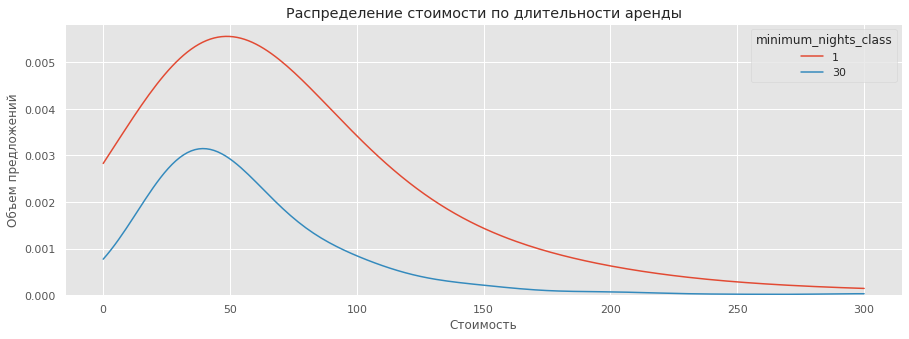

In [61]:
# Распределение стоимости по длительности аренды
sns.kdeplot(data=df_copy, x='price', hue='minimum_nights_class', clip=(0, 300))
plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по длительности аренды')

####                                        Анализ параметра number_of_reviews

In [62]:
df_copy['number_of_reviews'].describe()

count    19895.000000
mean        32.144861
std         63.004152
min          0.000000
25%          0.000000
50%          4.000000
75%         34.000000
max        761.000000
Name: number_of_reviews, dtype: float64

Text(0.5, 1.0, 'Распределение количества отзывов')

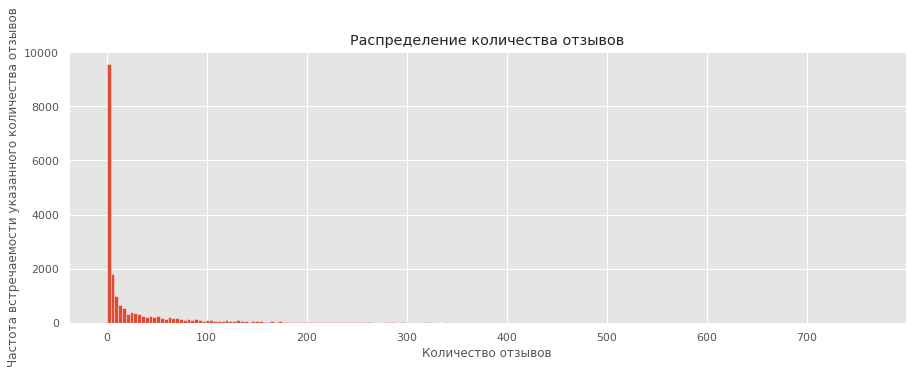

In [63]:
# Распределение параметра number_of_reviews
df_copy['number_of_reviews'].hist(bins=200)
plt.xlabel('Количество отзывов')
plt.ylabel('Частота встречаемости указанного количества отзывов')
plt.title('Распределение количества отзывов')

In [64]:
# количество предложений без отзывов
df_copy['number_of_reviews'].value_counts(normalize=True)

0      0.295351
1      0.097261
2      0.050214
3      0.038251
4      0.028650
         ...   
343    0.000050
470    0.000050
454    0.000050
438    0.000050
455    0.000050
Name: number_of_reviews, Length: 431, dtype: float64

#### Анализ параметра reviews_per_month

In [65]:
df_copy['reviews_per_month'].describe()

count    19895.000000
mean         0.778579
std          1.156461
min          0.000000
25%          0.000000
50%          0.230000
75%          1.120000
max         19.290000
Name: reviews_per_month, dtype: float64

Text(0.5, 1.0, 'Распределение количества ежемесячных отзывов')

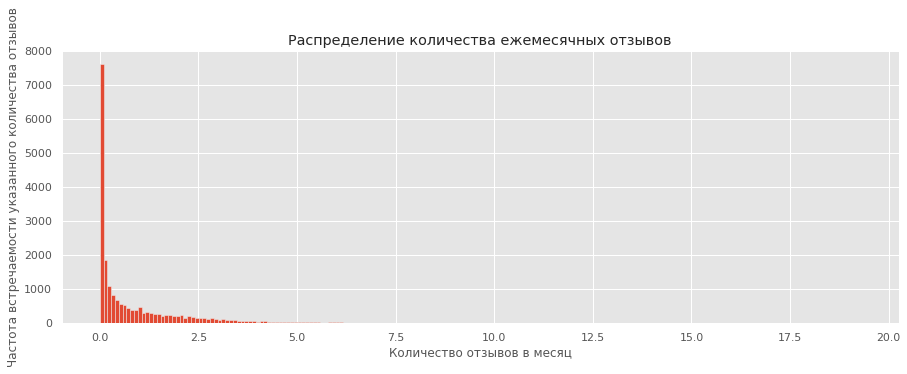

In [66]:
# Распределение параметра reviews_per_month
df_copy['reviews_per_month'].hist(bins=200)
plt.xlabel('Количество отзывов в месяц')
plt.ylabel('Частота встречаемости указанного количества отзывов')
plt.title('Распределение количества ежемесячных отзывов')

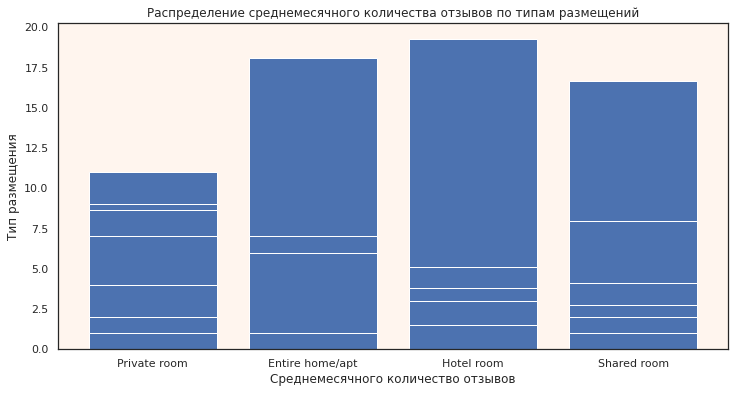

In [89]:
# распределение среднемесячного количества отзывов по типам размещений 
# (добавить разделение по сроку аренды minimum_nights_class)



x = df_copy['room_type']
y1 = df_copy['reviews_per_month']

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(12)  #  ширина Figure
fig.set_figheight(6)  #  высота Figure
plt.xlabel('Среднемесячного количество отзывов')
plt.ylabel('Тип размещения')
plt.title('Распределение среднемесячного количества отзывов по типам размещений')

plt.show()

####                                Анализ параметра neighbourhood_group

In [97]:
df_copy['neighbourhood_group'].value_counts(normalize=True)

Eixample               0.336768
Ciutat Vella           0.238703
Sants-Montjuïc         0.113596
Sant Martí             0.101935
Gràcia                 0.083941
Sarrià-Sant Gervasi    0.042222
Horta-Guinardó         0.031666
Les Corts              0.021111
Sant Andreu            0.016537
Nou Barris             0.013521
Name: neighbourhood_group, dtype: float64

Text(0.5, 1.0, 'Количество предложений для аренды по районам')

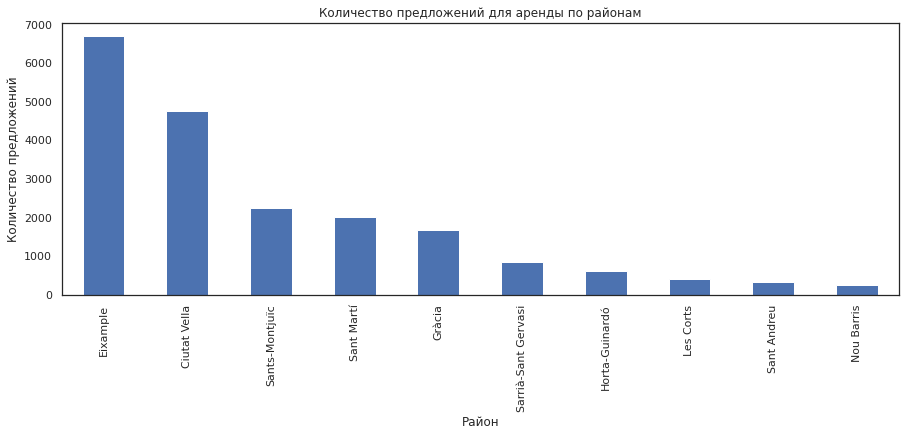

In [90]:
# Количество предложений для аренды по районам
df_copy['neighbourhood_group'].value_counts().plot.bar()
plt.xlabel('Район')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по районам')

In [69]:
# карта номеров групп районов
neighbourhood_set = set(df_copy['neighbourhood_group'])

neighbourhood_dict = {}

for i, area_name in enumerate(neighbourhood_set):
    neighbourhood_dict[area_name] = i + 1

In [70]:
# Добавление номера для групп районов
df_copy['neighbourhood_group_index'] = df_copy['neighbourhood_group'].map(
    neighbourhood_dict)

Text(0.5, 1.0, 'Распределение стоимости по группам районов')

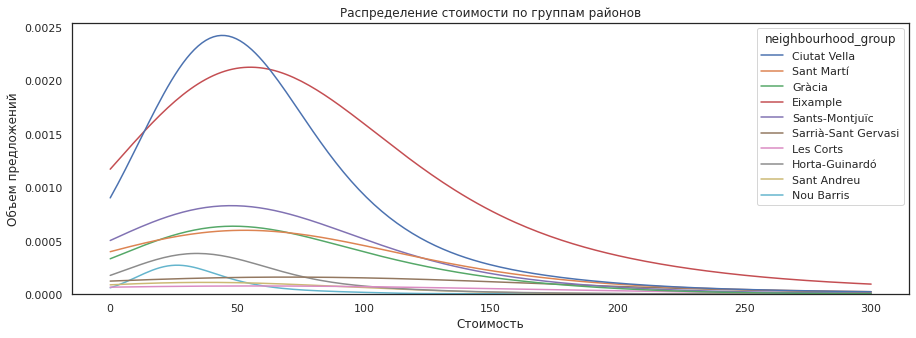

In [96]:
# Распределение стоимости по группам районов
sns.kdeplot(data=df_copy, x='price', hue='neighbourhood_group', clip=(0, 300))

plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по группам районов')

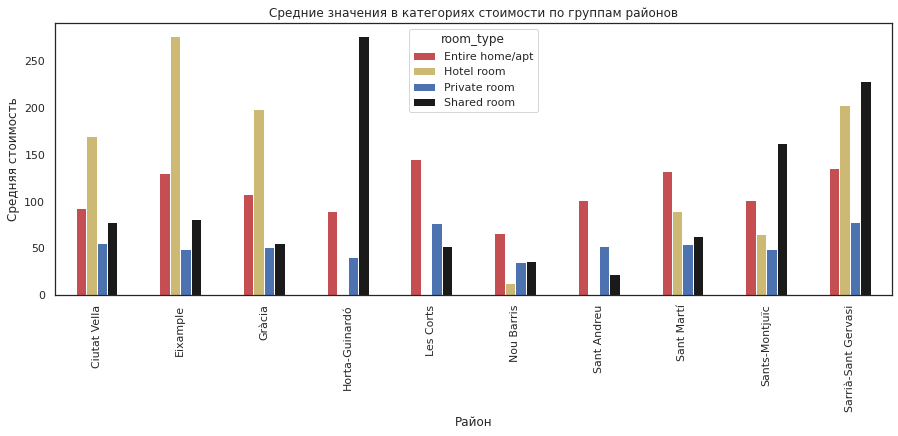

In [99]:
# Распределение типов предложений для аренды по группам районов
pd.pivot_table(df_copy,
               index='neighbourhood_group',
               columns='room_type',
               values='price').plot(kind='bar', color=['r', 'y', 'b', 'k','g'])
plt.xlabel('Район')
plt.ylabel('Средняя стоимость')
plt.title('Распределение типов предложений для аренды по группам районов');

In [ ]:
# приведение выбросов в районах Horta-Guinardó и Sarrià-Sant Gervasi к средним значениям по районам



#### Анализ параметра neighbourhood 

In [77]:
# карта номеров районов
neighbourhood_set = set(df_copy['neighbourhood'])

neighbourhood_dict = {}

for i, area_name in enumerate(neighbourhood_set):
    neighbourhood_dict[area_name] = i + 1

In [78]:
# Добавление номера для районов
df_copy['neighbourhood_index'] = df_copy['neighbourhood'].map(
    neighbourhood_dict)

<AxesSubplot:xlabel='neighbourhood'>

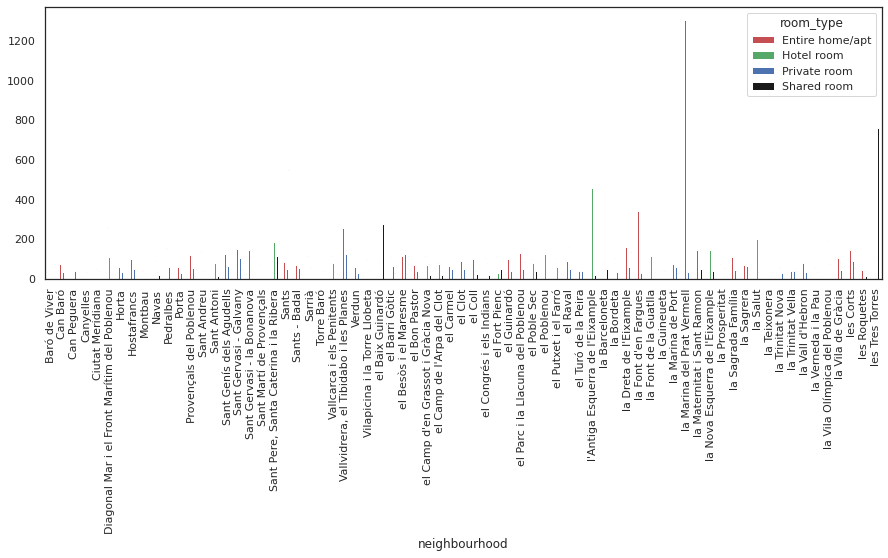

In [79]:
# средняя цена по кварталам
pd.pivot_table(df_copy,
               index='neighbourhood',
               columns='room_type',
               values='price').plot(kind='bar', color=['r', 'g', 'b', 'k'])

In [80]:
pivot_table_categories = df_copy.pivot_table(values=['price'],
                                             index=['neighbourhood'])
pivot_table_categories

,price
neighbourhood,
Baró de Viver,22.000000
Can Baró,50.628571
Can Peguera,37.666667
Canyelles,32.500000
Ciutat Meridiana,42.571429
...,...
la Vila Olímpica del Poblenou,149.068421
la Vila de Gràcia,83.114692
les Corts,115.363248


#### Анализ параметров latitude и longitude

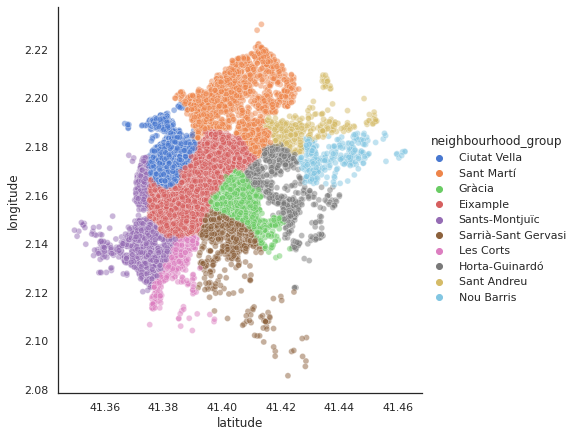

In [101]:
# Распределение геоданных по кластерам групп районов
sns.set_theme(style='white')

sns.relplot(x='latitude',
            y='longitude',
            hue='neighbourhood_group',
            sizes=(40, 400),
            alpha=.5,
            palette='muted',
            height=6,
            data=df_copy)

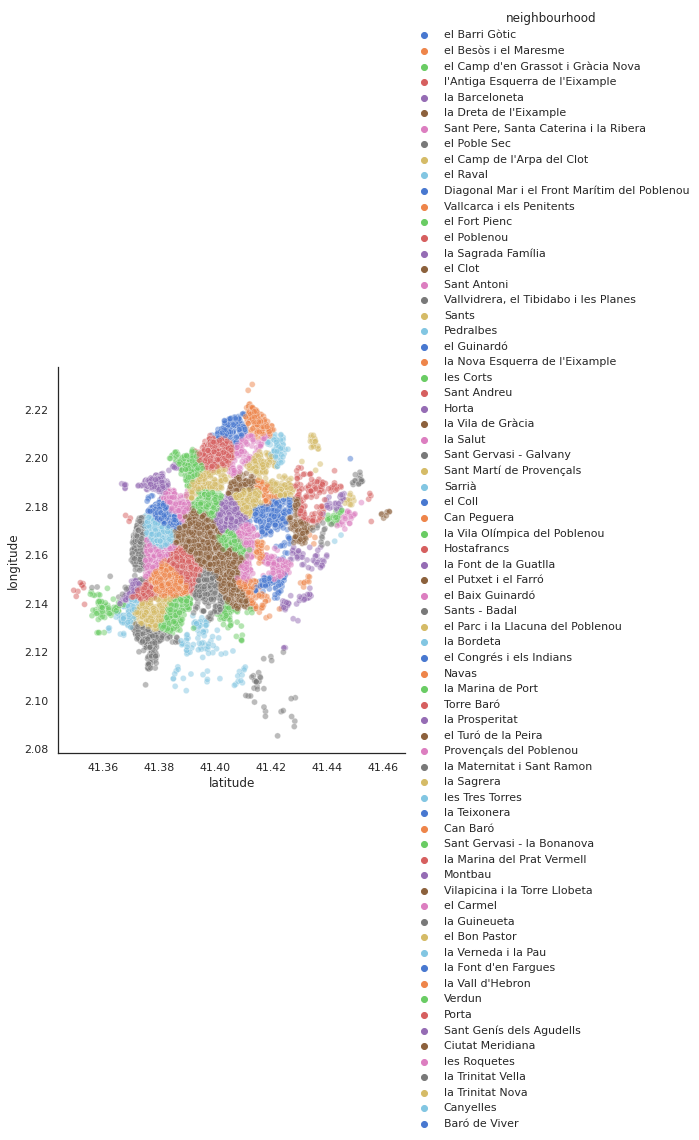

In [102]:
# Распределение геоданных по кластерам районов
sns.set_theme(style='white')

sns.relplot(x='latitude',
            y='longitude',
            hue='neighbourhood',
            sizes=(60, 50),
            alpha=.5,
            palette='muted',
            height=6,
            data=df_copy)

####                                     Анализ параметра availability_365

Text(0.5, 1.0, 'Количество доступных дней для бронирования')

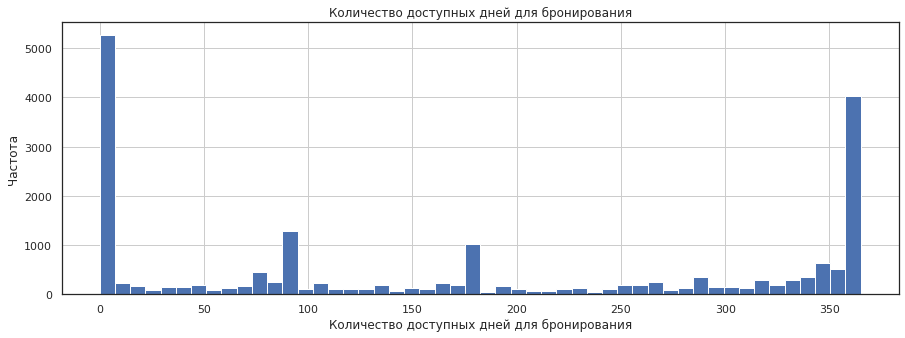

In [81]:
# распределение параметра availability_365
df_copy['availability_365'].hist(bins=50)
plt.xlabel('Количество доступных дней для бронирования')
plt.ylabel('Частота')
plt.title('Количество доступных дней для бронирования')

Text(0.5, 1.0, 'Наиболее востребованные районы')

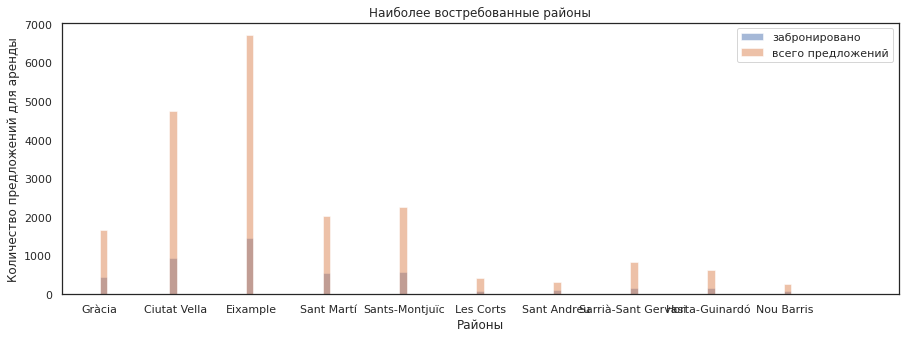

In [82]:
# Наиболее востребованные районы по availability_365
#выбор 2х столбцов по заданному фильтру
filtered_availability = df_copy[['availability_365', 'neighbourhood_group']]

# жилье недоступное для бронирования
filtered_availability = filtered_availability[
    filtered_availability['availability_365'] == 0]

# Наиболее востребованные районы
X = filtered_availability['neighbourhood_group']
Y = df_copy['neighbourhood_group']

bins = np.linspace(0, 10, 100)

plt.hist(X, bins, alpha=0.5, label='забронировано')
plt.hist(Y, bins, alpha=0.5, label='всего предложений')
plt.legend(loc='upper right')
plt.xlabel('Районы')
plt.ylabel('Количество предложений для аренды')
plt.title('Наиболее востребованные районы')

# разбить забронированное жилье по стоимости

#### Анализ параметра last_review 

In [83]:
# корректировка формата даты
df_copy['last_review_dt'] = pd.to_datetime(df_copy['last_review'],
                                           format='%Y-%m-%d')

In [84]:
# Влияние даты последнего отзыва на стоимость

<AxesSubplot:xlabel='last_review_dt', ylabel='Density'>

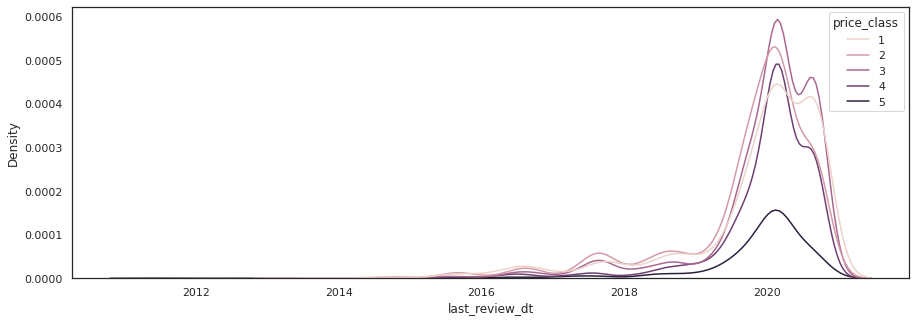

In [85]:
# сравнить недвижимость с отзывами за последние 6 месяцев и без в каждой ценовой категории
sns.kdeplot(data=df_copy, x='last_review_dt', hue='price_class')

#### Numeric columns

In [86]:
df_copy_numeric = df_copy.select_dtypes(include=[np.number])
numeric_cols = df_copy_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365' 'price_class' 'room_class' 'neighbourhood_group_index'
 'neighbourhood_index']


### Нерелевантные признаки

In [87]:
# удаление неинформативных признаков name, last_review и host_name
df_copy = df_copy.drop(['name', 'last_review', 'host_name'], axis=1)

### Сводная таблица факторов к стоимости

In [88]:
pivot_table_categories = df_copy.pivot_table(values=['price'],
                                             index=[
                                                 'neighbourhood_group',
                                                 'room_type',
                                                 'minimum_nights_class',
                                                 'number_of_reviews_class'
                                             ])
pivot_table_categories

KeyError: 'number_of_reviews_class'

### Порядковая регрессия

In [ ]:
from bevel.linear_ordinal_regression import OrderedLogit

In [ ]:
# тест модели с взаимозаменяемыми вариантами: neighbourhood_index, neighbourhood_group_index, latitude+longitude

# Назначение зависимых(Y) и независимых(X) переменных
Y = df_copy.price_class
X = df_copy[[
    'neighbourhood_index', 'room_class', 'availability_365',
    'calculated_host_listings_count', 'number_of_reviews', 'minimum_nights',
    'reviews_per_month'
]]

In [ ]:
X.dtypes

In [ ]:
# Построение регрессионной модели
model = OrderedLogit()
model.fit(X, Y)

In [ ]:
model.print_summary()

In [ ]:
# df_copy.sample(5)